# Homework 4

In previous homework we cleaned the data describing the numer of cell phones in every country in th eperiod from 1960 to 2019. In this paper we will merge this data with population data so we can find values describing phones per capita and more. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cell_phones = pd.read_csv("clean_cell_phones.csv")
pop = pd.read_csv("pop_data.csv")

df1_long = cell_phones.melt(id_vars ='iso-3', var_name='year', value_name='n_cellphones')
df2_long = pop.melt(id_vars='iso-3', var_name='year', value_name='population')

merged = pd.merge(df1_long, df2_long, on = ['iso-3', 'year'], how="inner")

We use the melt function to create dataframes such that the frist two columns are iso-3 and year. Then we merge them into one dataframe.

Next we want to combine the data from n_cellphones and year by finding the ratio of cellphones per person. 

In [2]:
country = pd.read_csv("country_data.csv")
country_sub = country[['alpha-3', 'name']]

full_name = merged.merge(country_sub, left_on ='iso-3', right_on= 'alpha-3', how = 'right') #merge the country and merged df:s
full_name = full_name.drop(columns = 'alpha-3')
full_name = full_name.drop(columns = 'iso-3')
full_name['cell_per_capita'] = full_name['n_cellphones']/full_name['population']

reshape = full_name.pivot(index='year', columns = 'name', values = 'cell_per_capita')# Pivot and reshape the dataframe 
reshape = reshape.dropna(axis = 1, how='all')
reshape = reshape.dropna(how='all')

max_2019 = reshape.sort_values(by='2019', axis=1, ascending = False)
max_2019.iloc[-5:, :5]

name,Macao,Hong Kong,United Arab Emirates,Antigua and Barbuda,Seychelles
year,,,,,
2015,3.088231,2.290401,2.007424,1.956838,1.584260
2016,3.143510,2.398931,2.212521,1.987545,1.605459
2017,3.210102,2.488773,2.183431,2.019337,1.742433
2018,3.348741,2.670209,2.199084,2.008164,1.849900
2019,3.284849,2.863650,2.127739,1.997460,1.987196


We read a dataset to find a map from the iso-3 to the full name of the country, combine with the previous dataset, find phones per capita and pivot from long format to wide format. Then we sort by the rows to find the highes phones per capita in 2019. 

Now, let us find which country has the highes growth rate of phones per capita during the latest ten years. 

In [3]:
max_2019 = max_2019.reset_index()
max_2019['year'] = pd.to_numeric(max_2019['year'], errors='coerce')
growth = pd.melt(max_2019.iloc[-5:, :10], id_vars = 'year', var_name = 'name', value_name = 'cell_per_capita')
sub_growth = growth[(growth['year'] >= 2009)]

<AxesSubplot: xlabel='year', ylabel='cell_per_capita'>

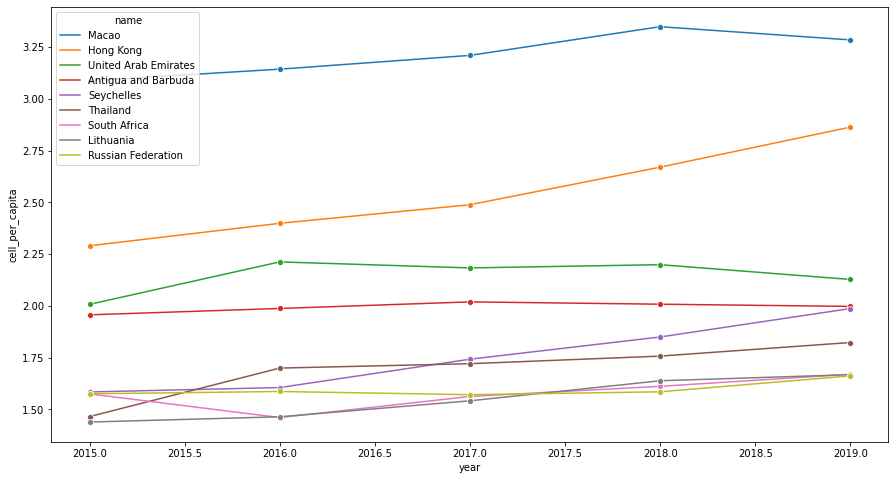

In [4]:
plt.figure(figsize = (15, 8))

sns.lineplot(data = sub_growth, x = 'year', y = 'cell_per_capita', hue='name', marker='o')

We use the melt() function to foramt the dataframe and use lineplot from seaborn to create the plot. Visually, we see that Hong Kong has the highest growt rate of cellphones per capita out of the ten countries with the highest ratio in 2019. 

### SQL

In this seqtion we will explore SQL a bit. We explore a database and analyse a table. 

Let us begin by reading and printing all users in the database.

In [5]:
import sqlite3
con = sqlite3.connect("user_actions.db") # connect to database

query = """
SELECT DISTINCT username
FROM user_actions
WHERE action = 'signup'
"""

signup_users = pd.read_sql(query, con)
signup_users

,username
0,user34
1,user28
2,user1
3,user24
4,user15
5,user20
6,user18
7,user25
8,user3
9,user9


We now want to find all log entries for each user. 

In [6]:
query = """
SELECT user_id, username, COUNT(*) AS log_count
FROM user_actions
GROUP BY user_id, username;
"""
log_counts = pd.read_sql(query, con)
log_counts

,user_id,username,log_count
0,1,user1,104
1,2,user2,149
2,3,user3,108
3,4,user4,436
4,5,user5,192
5,6,user6,457
6,7,user7,362
7,8,user8,329
8,9,user9,118
9,10,user10,170


Let us now identify a user who has both logged in and signed up on the same day. 

In [7]:
query = """
SELECT DISTINCT ua1.user_id, ua1.username
FROM user_actions ua1
JOIN user_actions ua2
    ON ua1.user_id = ua2.user_id
    AND DATE(ua1.timestamp) = DATE(ua2.timestamp)
WHERE ua1.action = 'signup' AND ua2.action = 'login';
"""
login_signup = pd.read_sql(query, con)
login_signup

,user_id,username
0,8,user8
1,12,user12
2,30,user30
3,7,user7
4,22,user22
5,5,user5
6,2,user2
7,32,user32


### Regex

In this section we will explore a .txt file using Regex. We use readlines() to get a list of all the comments and we use findall() to find the tags using the re library.

In [8]:
import re

with open('comments.txt', 'r') as file:
    comments = file.readlines()
    
tag_list = re.findall("#\w+",  comments[0])
tag_list

['#programming', '#tips']

We now want to create a regular experesison to find comments that mention both "#programming" and "#python". 

In [9]:
regex = "(?=.*#programming)(?=.*#python)"

contains_both = bool(re.search(regex, comments[1]))
print(contains_both)  

False


When testing the conde on comment 2 we get false, which is expected since comment 2 only include #python. However, if you test on comment 6 you get true since the comment include both of the tags. 

We can find all tags in the .txt file by iterating over all lines

In [10]:
tag_list = []
for i in range(len(comments)):
    tag_list.append(re.findall("#\w+",  comments[i]))
tag_list

[['#programming', '#tips'],
 ['#coding', '#python'],
 ['#tech', '#data'],
 ['#programming', '#coding'],
 ['#data', '#analysis'],
 ['#programming', '#python', '#tips'],
 ['#tech', '#innovation'],
 ['#coding', '#python'],
 ['#data', '#analytics'],
 ['#programming', '#tips'],
 ['#coding', '#python'],
 ['#tech', '#data'],
 ['#programming', '#coding'],
 ['#data', '#insights'],
 ['#programming', '#python', '#tips'],
 ['#tech', '#research'],
 ['#coding', '#python'],
 ['#data', '#analytics'],
 ['#programming', '#tips'],
 ['#coding', '#innovation'],
 ['#programming', '#python', '#tips'],
 ['#tech', '#data'],
 ['#coding', '#python'],
 ['#data', '#analytics'],
 ['#programming', '#tips'],
 ['#coding', '#python'],
 ['#tech', '#innovation'],
 ['#programming', '#coding'],
 ['#data', '#analytics'],
 ['#programming', '#python', '#tips'],
 ['#coding', '#innovation'],
 ['#tech', '#data'],
 ['#programming', '#tips'],
 ['#coding', '#python'],
 ['#data', '#analysis'],
 ['#programming', '#tips'],
 ['#coding'